# Urbanization Index Comparisons with Global Human Settlement (GHS)

* **Products used:** 
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2)

## Background
There are many different urbanization indices with different characteristics and use cases. It is often convenient to be able to compare the performance of several  indicies for an area - determining which is the best for an area based on the outputs and a "ground truth" dataset of urbanization.

## Description

This notebook uses several indices to classify land as "urban" and then compares those results with the [Global Human Settlement (GHS) product](https://ghsl.jrc.ec.europa.eu/ghs_bu2019.php) which shows the extent of built-up area (urban extent) through to 2014. The indices tested here are the Normalized **Difference Buildup Index (NDBI)** and the **Enhanced Normalized Difference Impervious Surface Index (ENDISI)**. 

The notebook selects a region of interest for the year 2014. A [geomedian cloud-filtered mosaic](../Frequently_used_code/Generating_geomedian_composites.ipynb) is created for the year and each urban index is calculated using the mosaic. In addition, a set of histograms is created for each index. The user then selects a minimum and maximum threshold value for each index to identify potential urban pixels. The choice and adjustment of the threshold values is supported by the histogram plots and the output comparisons with the GHS dataset (more below).

Next, the GHS dataset is loaded for the region of interest and the urban extent is shown for the year 2014. Finally, the urban extent products from each of the indices is compared with the GHS product and the accuracy is evaluated. The code will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important, while the F1-score is used when the False Negatives and False Positives are crucial.

1. Select a region of interest.
2. Create a cloud-filtered median mosaic with data for the year 2014.
3. Show histograms for the indicies.
4. Select minimum and maximum threshold values for the indicies to determine urban pixels.
5. Show the urbanization prediction images.
6. Load and show the "ground truth" data (GHS) for the year 2014.
7. Compare the urbanization predictions with the "ground truth" data visually and statistically.

The choice of threshold values can be informed by the histograms and comparing the urbanization prediction images with the "ground truth" urbanization data.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import numpy as np
import xarray as xr
import pandas as pd
from collections import namedtuple
from datacube.utils.geometry import assign_crs
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from matplotlib.patches import Patch
from odc.algo import xr_geomedian, to_f32
from odc.algo import xr_reproject

from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, wofs_fuser
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.bandindices import calculate_indices

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:40369 Dashboard: /user/fangfy/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Urbanization_GHS_Comparison")

### Analysis parameters

The following cell sets important parameters for the analysis. The parameters are:

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `lat_buffer`: The number of degrees to load around the central latitude.
* `lon_buffer`: The number of degrees to load around the central longitude.
* `time_range`: The time range to analyze - in YYYY-MM-DD format (e.g. `('2016-01-01', '2016-12-31')`).

**If running the notebook for the first time**, keep the default settings below.
The default area is Dakar, Senegal.

#### Suggested areas
Here are some suggestions for areas to look at. To view one of these areas, copy and paste the parameter values into the cell below, then run the notebook.

**Dodoma, Tanzania**
```
lat = -6.1696
lon = 35.748
lat_buffer = 0.0356
lon_buffer = 0.036
```

**Dar es Salam, Tanzania**
```
lat = -6.8205
lon = 39.219
lat_buffer = 0.1505
lon_buffer = 0.129
```

**Nairobi, Kenya**
```
lat = -1.28
lon = 36.85
lat_buffer = 0.12
lon_buffer = 0.15
```

**Kumasi, Ghana**
```
lat =  6.7012
lon = -1.60825
lat_buffer = 0.1722
lon_buffer = 0.18715
```

**Dakar, Senegal**
```
lat = 14.72
lon = -17.355
lat_buffer = 0.19
lon_buffer = 0.215
```

### Select location

In [4]:
# Define the area of interest
lat = 14.72
lon = -17.355
lat_buffer = 0.15
lon_buffer = 0.2

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Time period
time_range = ("2014-01-01", "2014-12-31")

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
# The code below renders a map that can be used to view the region.
display_map(lon_range, lat_range)

## Load the data
We can use the [load_ard](Using_load_ard.ipynb) function to load data from multiple satellites (e.g. Landsat 7 and Landsat 8), and return a single `xarray.Dataset`.

In [6]:
# Create the 'query' dictionary object
query = {
    "longitude": lon_range,
    "latitude": lat_range,
    "time": time_range,
    "resolution": (-30, 30),
    "dask_chunks": {'time': 1,'x':1000,'y':1000},
    "group_by": "solar_day",
    "output_crs": 'EPSG:6933'
}

# Load available data
landsat_dataset = load_ard(
    dc=dc,
    products=["ls8_sr"],
    min_gooddata=0.2,
    measurements=["red", "green", "blue", "swir_1", "swir_2", "nir"],
    **query
)


/home/jovyan/dev/deafrica-sandbox-notebooks/Tools/deafrica_tools/datahandling.py:261: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  "Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 35 out of 44 time steps with at least 20.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 35 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` attribute revels the number of time steps in the data set, as well as the number of pixels in the `longitude` and `latitude` dimensions.

In [7]:
landsat_dataset

<xarray.Dataset>
Dimensions:      (time: 35, x: 1287, y: 1236)
Coordinates:
  * time         (time) datetime64[ns] 2014-01-05T11:28:48.621976 ... 2014-12...
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.839e+06 1.839e+06
  * x            (x) float64 -1.694e+06 -1.694e+06 ... -1.655e+06 -1.655e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir_2       (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Filter out water pixels using WOfS

In [8]:
# Create a water mask using WOfS.
water = dc.load(
    product=["ga_ls8c_wofs_2"],
    fuse_func=wofs_fuser, **query).water

water = water.sel(time=landsat_dataset.time, method='nearest')
water = water.isin([128,130,160,162,192])

# Mask out water.
water_mask = water.mean('time') > 0.1
landsat_dataset = landsat_dataset.where(~water_mask)

### Create a geomedian mosaic

In [9]:
#scale the values to 0-1 using the to_f32 util function
landsat_dataset = to_f32(landsat_dataset,
                   scale=1/10000,
                   offset=0)

#calculate the geomedian
land_composite = xr_geomedian(landsat_dataset,
                              num_threads=1,
                              eps=1e-7).compute()

## Land Spectral Indices

We're going to be calculating NDBI and ENDISI as urbanization indices.

> ### NDBI
The Normalized Difference Built-Up Index (NDBI) is one of the most commonly used proxies of urbanization. Like all normalized difference indicies, it has a range of \[-1,1\].

$$
\begin{aligned}
\text{NDBI} = \frac{\text{SWIR1} - \text{NIR}}{\text{SWIR1} + \text{NIR}}
\end{aligned}
$$

> ### ENDISI
The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a more recently developed urbanization proxy. Like all normalized difference indicies, it has a range of \[-1,1\].
Note that `MNDWI`, `swir_diff` and `alpha` are all part of the ENDISI calculation.

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}}
\end{aligned}
$$

$$
\begin{aligned}
\text{swir_diff} = \frac{\text{SWIR1}}{\text{SWIR2}}
\end{aligned}
$$

$$
\begin{aligned}
\text{alpha} = \frac{\text{2*mean(BLUE)}}{\text{mean(swir_diff) + mean(MNDWI^2)}}
\end{aligned}
$$

$$
\begin{aligned}
\text{ENDISI} = \frac{\text{BLUE} - \text{alpha}*(\text{swir_diff} + \text{MNDWI^2})}
{\text{BLUE} + \text{alpha}*(\text{swir_diff} + \text{MNDWI^2})}
\end{aligned}
$$

### Calculate NDBI and ENDISI

In [10]:
#NDBI and ENDISI using DE Africa funciton calculate_indices
land_composite = calculate_indices(land_composite, index=['NDBI', "ENDISI"], collection='c2')

### Plot the two urban indices

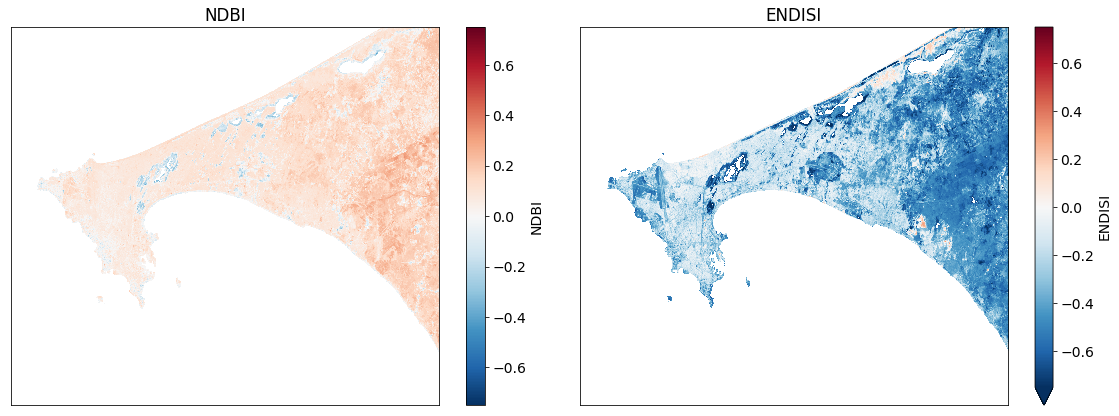

In [11]:
#Plot
fig, ax = plt.subplots(1, 2, figsize=(16,6), sharey=True)
land_composite.NDBI.plot(ax=ax[0], vmin=-.75, vmax=.75, cmap='RdBu_r')
land_composite.ENDISI.plot.imshow(ax=ax[1], vmin=-.75, vmax=.75, cmap='RdBu_r')
ax[0].set_title('NDBI'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('ENDISI'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.tight_layout();

## Determining the thresholds for urbanization
These histogram plots show the distribution of values for each product.
The urban threshold values are chosen using these histograms.

If a highly urban area is being examined, there should be visible maximal values for these histograms. The ideal thresholds should usually include these values (see the x axes of the histograms) and some range of values less than and greater than these maximal values.

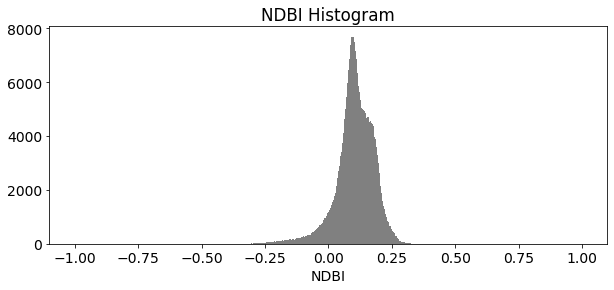

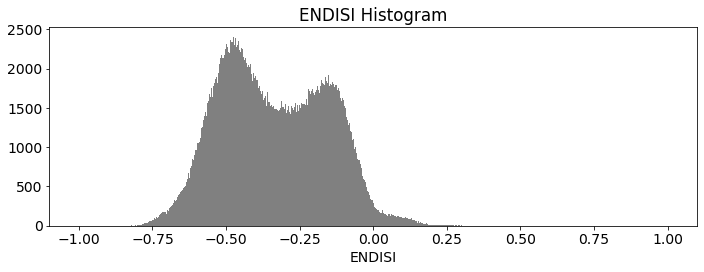

In [12]:
#NDBI
land_composite.NDBI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('NDBI Histogram')

#ENDISI
land_composite.ENDISI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('ENDISI Histogram')

plt.tight_layout();

## Create Threshold Plots
First we will define a minimum threshold and a maximum threshold for each index. Then we will create plots that color the threshold region a single color (e.g. red).

In [13]:
# NDBI (Buildup Index) = -1.0 to 1.0 (full range)
# NDBI -0.1 to 0.3 is typical for urban areas
min_ndbi_threshold = -0.1
max_ndbi_threshold = 0.125

# ENDISI = -1.0 to 1.0 (full range)
# ENDISI -0.2 to 0.4 is typical for urban areas
min_endisi_threshold = -0.3
max_endisi_threshold = 0.1


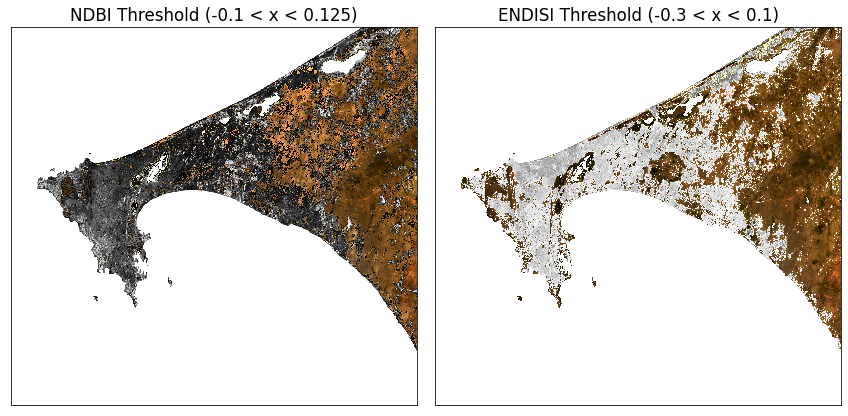

In [14]:
# Set up the sub-plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

rgb(land_composite, ax=ax[0])
land_composite.NDBI.where((land_composite.NDBI > min_ndbi_threshold) &
                          (land_composite.NDBI < max_ndbi_threshold)).plot.imshow(
                              cmap='Greys',
                              ax=ax[0],
                              robust=True,
                              add_colorbar=False,
                              add_labels=False)

rgb(land_composite, ax=ax[1])
land_composite.ENDISI.where((land_composite.ENDISI > min_endisi_threshold) &
                            (land_composite.ENDISI < max_endisi_threshold)).plot.imshow(
                                  cmap='Greys',
                                  ax=ax[1],
                                  robust=True, 
                                  add_colorbar=False,
                                  add_labels=False)

#remove axes plotting elements
for a in ax:
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)

#set titles
ax[0].set_title(f'NDBI Threshold ({min_ndbi_threshold} < x < {max_ndbi_threshold})')
ax[1].set_title(f'ENDISI Threshold ({min_endisi_threshold} < x < {max_endisi_threshold})')
plt.tight_layout();

## Comparison Metrics
We will compare the performance of the urban index results against the GHS GeoTIFF product (shown below).

The GHS geotiff for the Senegal region is available by default in the `Supplementary_data` folder. To find and download GHS geotiffs for other regions, use the following link: https://ghsl.jrc.ec.europa.eu/download.php?ds=bu


In [15]:
# Senegal region
tif = '../Supplementary_data/Urban_index_comparison/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif'

### Open and reproject dataset to match Landsat

In [16]:
#Open and assign a geobox object
ghs_ds = assign_crs(xr.open_rasterio(tif).squeeze().chunk({'x':5000, 'y':5000}))

#reproject to match our landsat composite
ghs_ds = xr_reproject(ghs_ds,
             land_composite.geobox,"nearest").compute()

#Threshold GHS to get all the urban areas
actual = (ghs_ds >= 3) & (ghs_ds <= 6)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


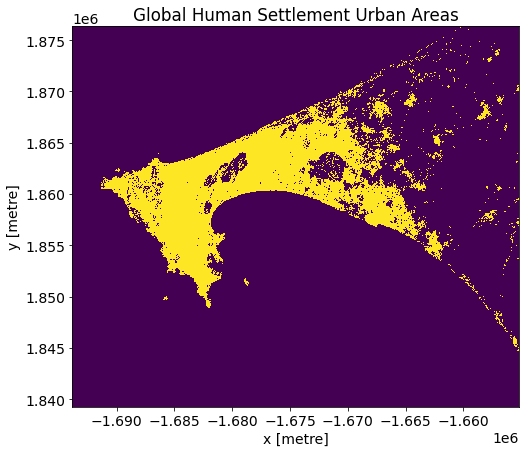

In [17]:
#Plot
actual.plot(figsize=(8,7), add_colorbar=False)
plt.title('Global Human Settlement Urban Areas');

## Metric and Plotting Functions
The code below will calculate the true/false positive/negative sums and calculate values for a typical confusion matrix to assess the results. Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$

In [18]:
def get_metrics(actual, predicted, minimum_threshold, maximum_threshold, filter_size=1):
    """ Creates performance metrics.
    
    Args:
        actual: the data to use as truth.
        predicted: the data to predict and to compare against actual.
        minimum_threshold: the minimum threshold to apply on the predicted values for generating a boolean mask.
        maximum_threshold: the maximum threshold to apply on the predicted values for generating a boolean mask.
        filter_size: the filter size to apply on predicted to remove small object/holes with.
        
    Returns: A namedtuple containing the actual, predicted mask, and varying metrics for a confusion matrix.
    """
    metrics = namedtuple('Metrics',
                         'actual predicted true_positive true_negative false_positive false_negative')

    predicted  = (predicted > minimum_threshold) & (predicted < maximum_threshold)
    predicted  = remove_small_objects(predicted, min_size=filter_size+1, connectivity=2)
    predicted  = remove_small_holes(predicted, area_threshold=filter_size+1, connectivity=2)

    true_positive=(predicted & actual).sum()
    true_negative=(~predicted & ~actual).sum()
    false_positive=(predicted & ~actual).sum()
    false_negative=(~predicted & actual).sum()

    return metrics(actual=actual,
                   predicted=predicted,
                   true_positive=true_positive,
                   true_negative=true_negative,
                   false_positive=false_positive,
                   false_negative=false_negative)

def print_metrics(metrics):
    norm = metrics.true_positive + metrics.false_negative + metrics.false_positive + metrics.true_negative
    accuracy = (metrics.true_positive + metrics.true_negative)/norm
    ppv = metrics.true_positive/(metrics.true_positive + metrics.false_positive)
    tpr = metrics.true_positive/(metrics.true_positive + metrics.false_negative)
    f1 = (2*ppv*tpr)/(ppv+tpr)
    
    print('True Positive (Actual + Model = Urban): {tp}'.format(tp=round(metrics.true_positive/norm*100,3)))
    print('True Negative (Actual + Model = Non-Urban): {tn}'.format(tn=round(metrics.true_negative/norm*100,3)))
    print('False Positive (Actual=Non-Urban, Model=Urban): {fp}'.format(fp=round(metrics.false_positive/norm*100,3)))
    print('False Negative (Actual=Urban, Model=Non-Urban): {fn}'.format(fn=round(metrics.false_negative/norm*100,3)))
    print('\nAccuracy: {accuracy}'.format(accuracy=round(accuracy*100, 3)))
    print('F1 Score: {f1}\n'.format(f1=round(f1*100, 3)))

In [19]:
indexes =['NDBI','ENDISI']
min_thresholds = [min_ndbi_threshold, min_endisi_threshold] 
max_thresholds =[max_ndbi_threshold, max_endisi_threshold]

index_metrics=[]
for index, min_thresh, max_thresh in zip(indexes, min_thresholds, max_thresholds):
    print ('\033[1m' + '\033[91m' + index+' - Comparison Results') # bold print and red
    print ('\033[0m') # stop bold and red
    metrics = get_metrics(actual.values, land_composite[index].values, min_thresh, max_thresh)
    index_metrics.append(metrics)
    print_metrics(metrics)

#create a dictionary with the accuracy data in it
index_metrics = {indexes[i]: index_metrics[i] for i in range(len(indexes))}

NDBI - Comparison Results

True Positive (Actual + Model = Urban): 11.519
True Negative (Actual + Model = Non-Urban): 79.306
False Positive (Actual=Non-Urban, Model=Urban): 7.789
False Negative (Actual=Urban, Model=Non-Urban): 1.387

Accuracy: 90.824
F1 Score: 71.516

ENDISI - Comparison Results

True Positive (Actual + Model = Urban): 9.874
True Negative (Actual + Model = Non-Urban): 83.325
False Positive (Actual=Non-Urban, Model=Urban): 3.769
False Negative (Actual=Urban, Model=Non-Urban): 3.031

Accuracy: 93.199
F1 Score: 74.385



/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


## Output Comparisons
The `dstack` calls provide the `imshow` calls with RGB array inputs. For each image, the first channel (red) is the actual (ground truth, GHS) values, and both the second and third channels (green, blue) are the predicted values (green + blue = cyan).

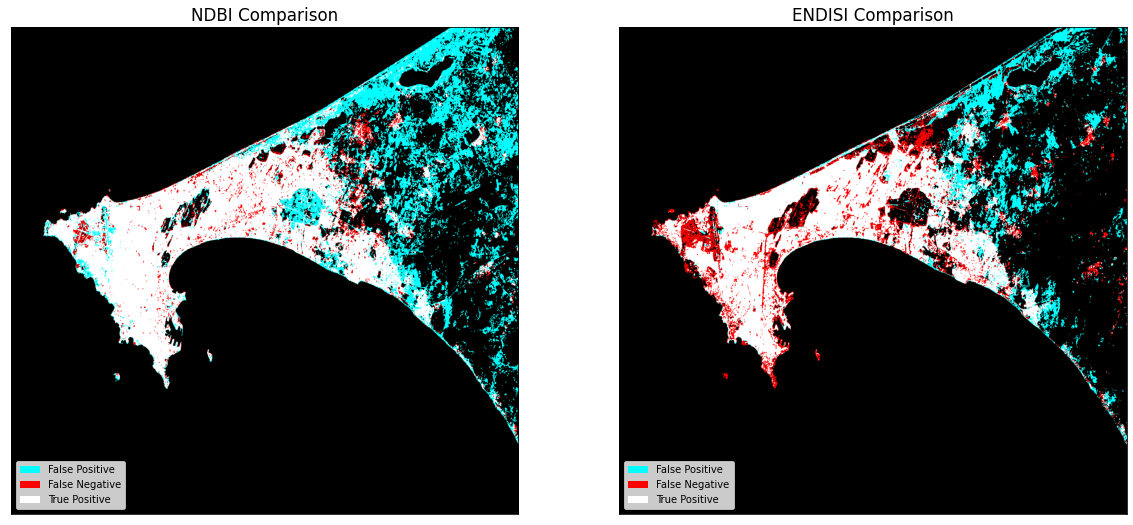

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

for a, key in zip(ax, index_metrics):
    a.imshow(np.dstack((index_metrics[key].actual.astype(float),
                        index_metrics[key].predicted.astype(float),
                        index_metrics[key].predicted.astype(float))))
    a.legend(
        [Patch(facecolor='cyan'), Patch(facecolor='red'), Patch(facecolor='white')], 
        ['False Positive', 'False Negative', 'True Positive'], loc='lower left', fontsize=10)
    a.xaxis.set_visible(False)
    a.yaxis.set_visible(False)
    a.set_title(key +' Comparison')

## Next Steps
Machine learning can also be used to measure urbanisation. See [this notebook](../Real_world_examples/Machine_learning_with_ODC.ipynb) for a guide on using machine learning in the context of the ODC.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


**Last Tested:**

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-20'